# House Sale Price Predictions
This notebook will attempt to predict sale prices of homes in the kaggle competition of House Prices - Advanced Regression Techniques

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score


In [35]:
train = pd.read_csv("train.csv")

In [36]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
train.shape

(1460, 81)

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [39]:
na_percent = train.isna().mean() * 100
na_percent

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64

Many NA values, some columns have few, some none, and some are almost all NA. Will need to develop good system to impute.

# Exploratory Data Analysis

<Axes: xlabel='SalePrice', ylabel='Count'>

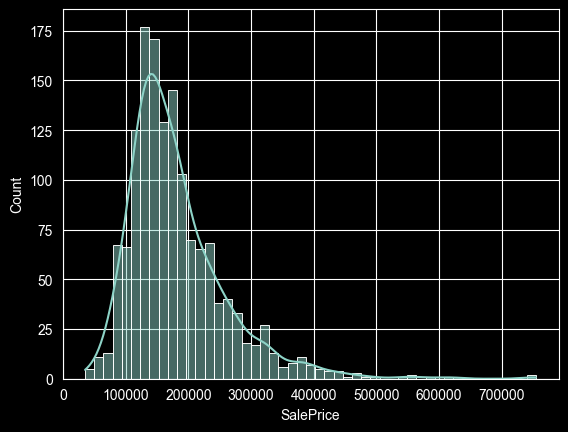

In [40]:
sns.histplot(data=train["SalePrice"], kde=True)

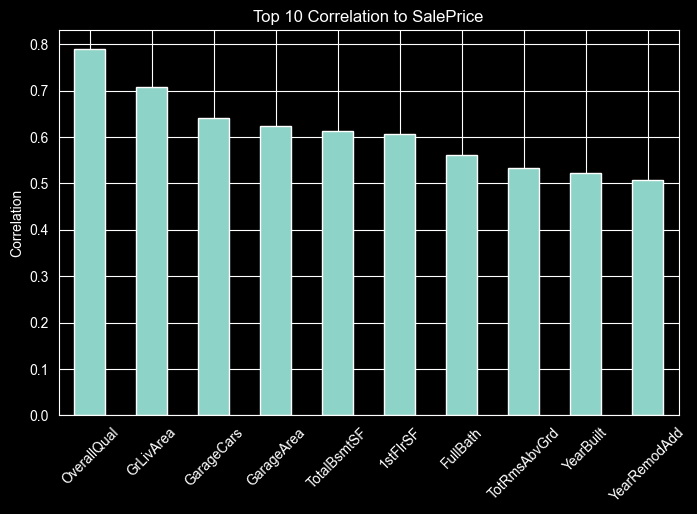

In [41]:
corr = train.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)[1:11]
plt.figure(figsize=(8,5))
corr.plot(kind="bar")
plt.title("Top 10 Correlation to SalePrice")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.show()


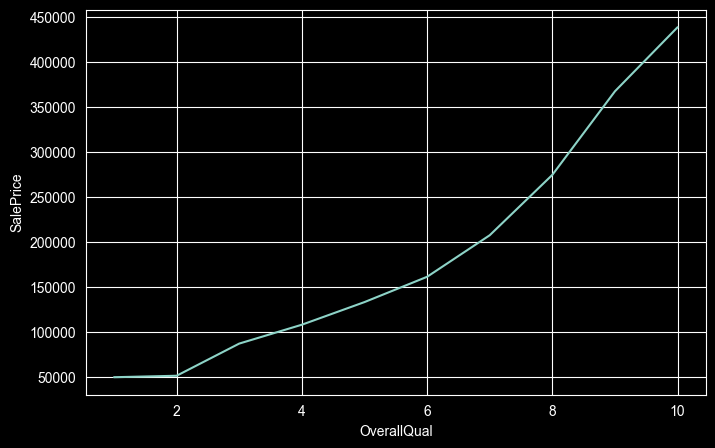

In [42]:
plt.figure(figsize=(8,5))
sns.lineplot(data= train, x="OverallQual", y="SalePrice", errorbar=None)
plt.show()

We will do a log transformation on Sale Price since it is a bit right skewed and see if that makes it more normal shaped.

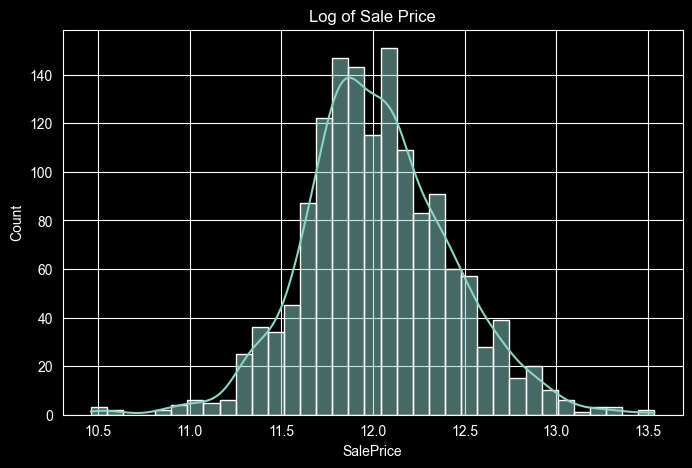

In [43]:
y = np.log1p(train["SalePrice"])
plt.figure(figsize=(8,5))
sns.histplot(data=y, kde=True)
plt.title("Log of Sale Price")
plt.show()

We will drop sale price and ID and now X dataframe will be our predictors.

In [44]:
X = train.drop(columns=["SalePrice", "Id"])

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [46]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numerical Features: ", len(num_features))
print("Categorical Features: ", len(cat_features))

Numerical Features:  36
Categorical Features:  43


Now that we have the numerical and categorical features seperated from each other we can build a simple pipeline for preprocessing.

In [47]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features),
])

For this Pipeline we are taking the splits we created before with num_features and cat_features. For the num_pipeline we are simply imputing the NA values with the columns median. For the cat_pipeline we are using the most frequent value to fill in NA values, we also are OneHotEncoding them to be ready to use in our models. We then build the preprocessor that uses each of those pipelines on the numerical and categorical features of the training data.

# Model Building

### Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score

linear = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression()),
])

linear_rmse = -cross_val_score(
    linear,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"Linear regression RMSE: {linear_rmse}")

Linear regression RMSE: 0.15646765604294946


### Ridge Regression

In [49]:
from sklearn.linear_model import Ridge
ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge()),
])

ridge_rmse = -cross_val_score(
    ridge,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"Ridge regression RMSE: {ridge_rmse}")

Ridge regression RMSE: 0.14506597357763296


### Lasso

In [50]:
from sklearn.linear_model import LassoCV
lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LassoCV(
        alphas=np.logspace(-4, 0, 50),
        cv=5,
        max_iter=5000
    )),
])
lasso_rmse = -cross_val_score(
    lasso,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"Lasso regression RMSE: {lasso_rmse}")

Lasso regression RMSE: 0.13831371851363092


### ENET

In [51]:
from sklearn.linear_model import ElasticNetCV
elasticnet = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ElasticNetCV(
        alphas=np.logspace(-4, 0, 50)
    )),
])
elasticnet_rmse = -cross_val_score(
    elasticnet,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"Elasticnet regression RMSE: {elasticnet_rmse}")

Elasticnet regression RMSE: 0.13768151074207957


### Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor
forest = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor()),
])
forest_rmse = -cross_val_score(
    forest,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"Forest regression RMSE: {forest_rmse}")

Forest regression RMSE: 0.14363555795373245


### XGBoost

In [53]:
from xgboost import XGBRegressor
xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(learning_rate=.05,
                           n_estimators=500,
                           max_depth=4,)),
])
xgb_rmse = -cross_val_score(
    xgb,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"XGBoost regression RMSE: {xgb_rmse}")

XGBoost regression RMSE: 0.12633263655690313


### Gradient Boosting

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor()),
])
gbm_rmse = -cross_val_score(
    gbm,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"GradientBoosting regression RMSE: {gbm_rmse}")

GradientBoosting regression RMSE: 0.12607142855253892


### LightGBM

In [55]:
from lightgbm import LGBMRegressor
lgbm = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMRegressor()),
])
lgbm_rmse = -cross_val_score(
    lgbm,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()
print(f"LightGBM regression RMSE: {lgbm_rmse}")

LightGBM regression RMSE: 0.1311842169901441


# Model Comparisons

In [56]:
comparison = pd.DataFrame({
    "Model": ["Linear", "Ridge", "Lasso", "ElasticNet", "RandomForestRegressor", "XGBoost", "GradientBoosting", "LGBM"],
    "CV_RMSE": [linear_rmse, ridge_rmse, lasso_rmse, elasticnet_rmse, forest_rmse, xgb_rmse, gbm_rmse, lgbm_rmse]
})
comparison = comparison.sort_values(by="CV_RMSE").reset_index(drop=True)
comparison

,Model,CV_RMSE
0,GradientBoosting,0.126071
1,XGBoost,0.126333
2,LGBM,0.131184
3,ElasticNet,0.137682
4,Lasso,0.138314
5,RandomForestRegressor,0.143636
6,Ridge,0.145066
7,Linear,0.156468


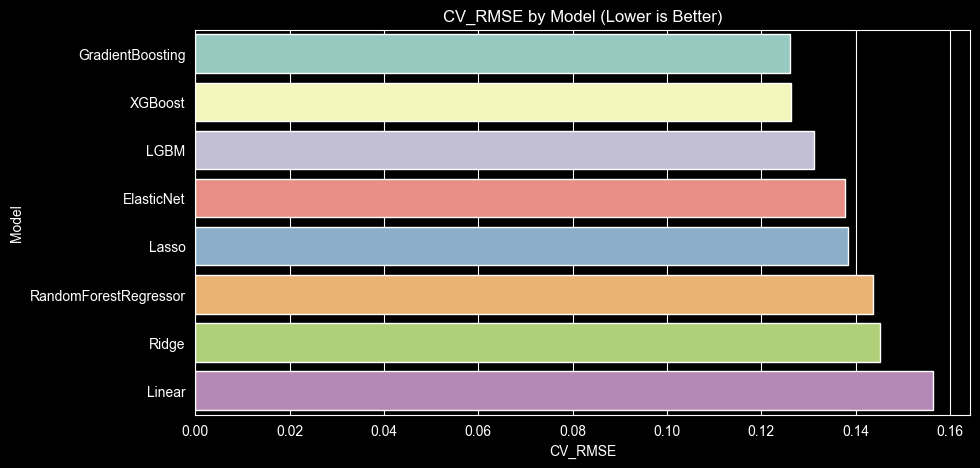

In [57]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=comparison,
    x="CV_RMSE",
    y="Model",
    hue="Model",
)
plt.title("CV_RMSE by Model (Lower is Better)")
plt.show()

We can see that XGBoost and Gradient Boosting were the favorites for models, as XGBoost and Gradient Boosting are similar I will just focus on picking XGBoost to work with on hyperparameter tuning.

In [58]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "model__max_depth": [2, 3, 4, 5, 6, 7],
    "model__n_estimators": [100, 200, 300, 400, 500],
    "model__learning_rate": [.04, .05, .06, .07, .08],
    "model__min_child_weight": [1, 2, 3, 4, 5],
    "model__subsample": [.6, .7, .8, .9],
    "model__colsample_bytree": [.6, .7, .8, .9],
}

xgb_real = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=50,
                           objective="reg:squarederror")),
])

search = RandomizedSearchCV(
    estimator=xgb_real,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=50
)
search.fit(X, y)

print("Best RMSE:" , -search.best_score_)
print("Best Params:", search.best_params_)


Best RMSE: 0.12012520425033572
Best Params: {'model__subsample': 0.8, 'model__n_estimators': 400, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.06, 'model__colsample_bytree': 0.7}


In [59]:
param_grid_2 = {
    "model__max_depth": [2, 3, 4],
    "model__n_estimators": [400, 500, 600],
    "model__learning_rate": [.03, .04, .05],
    "model__min_child_weight": [1, 2],
    "model__subsample": [.6, .7, .8],
    "model__colsample_bytree": [.6, .7, .8],
    "model__gamma": [0, .05, .1, .2],
    "model__reg_alpha": [0, 0.001, 0.01, 0.1],
    "model__reg_lambda": [0, 1, 5, 10]
}

search2 = RandomizedSearchCV(
    estimator=xgb_real,
    param_distributions=param_grid_2,
    n_iter=100,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=50
)
search2.fit(X, y)
print("Best RMSE:" , -search2.best_score_)
print("Best Params:", search2.best_params_)

Best RMSE: 0.12013064193141758
Best Params: {'model__subsample': 0.8, 'model__reg_lambda': 1, 'model__reg_alpha': 0, 'model__n_estimators': 600, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__gamma': 0, 'model__colsample_bytree': 0.7}


We can see that doing a second search with different hyperparmeters has had almost no change in the RMSE from the first. It is unlikely that continuing with another search would significantly improve the predictive power of the model. However, this hyperparameter optimized model did show significant improvement from the origanl model, going from a RMSE of 0.12633 to 0.12013.

### Further Improvements
To further improve and decrease our RMSE score I would attempt more specific feature engineering on the data before training the models. We are given lots of predictor variables, and my current pipeline was very simple in just filling in the NA values with simple options. A very in depth look at feature engineering would be the next step to take.

### Model Interpretation
With an RMSE on the log transformed sale price of 0.1201, this can be interpreted as a average prediction error of roughly ~12%. This means that on average the models predictive ability was different from the true sale prices of houses by about 12%. We found that linear models such as Lasso or Ridge performed worse than tree models such as XGboost or RandomForest. This implies that there may be some non linear relationships in the data that the linear models did not account for as well as the tree models.

In [60]:
best_model = search2.best_estimator_

In [61]:
test = pd.read_csv("test.csv")
X_test = test.drop(columns=["Id"])


In [62]:
best_model.fit(X, y)
final_preds = np.expm1(best_model.predict(X_test))

In [63]:
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": final_preds
})
submission.head()

,Id,SalePrice
0,1461,123900.890625
1,1462,156128.015625
2,1463,188332.640625
3,1464,192731.921875
4,1465,183412.984375


In [64]:
submission.to_csv("submission.csv", index=False)